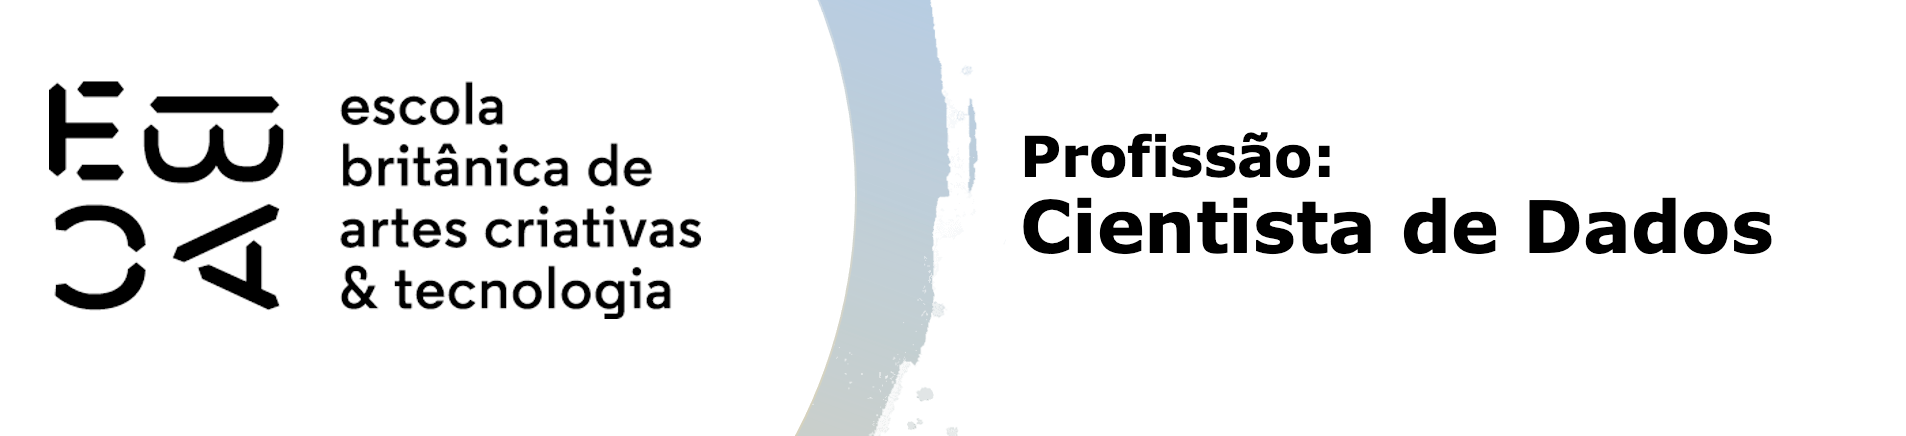

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [5]:
# Manipulação de dados
import pandas as pd

# Scikit-learn - Pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Scikit-learn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn - Avaliação de modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

from sklearn.decomposition import PCA

from pycaret.classification import *


df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


Amostragem movida para o desenvolvimento do modelo para facilitar o trabalho.

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
                          'educacao', 'estado_civil', 'tipo_residencia']

for col in variaveis_qualitativas:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True) * 100)


--- sexo ---
sexo
F    504580
M    245420
Name: count, dtype: int64
sexo
F    67.277333
M    32.722667
Name: proportion, dtype: float64

--- posse_de_veiculo ---
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64
posse_de_veiculo
N    61.060533
S    38.939467
Name: proportion, dtype: float64

--- posse_de_imovel ---
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64
posse_de_imovel
S    67.158933
N    32.841067
Name: proportion, dtype: float64

--- tipo_renda ---
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64
tipo_renda
Assalariado         51.432000
Empresário          23.028267
Pensionista         16.835333
Servidor público     8.656267
Bolsista             0.048133
Name: proportion, dtype: float64

--- educacao ---
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental      

In [7]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

print(df[variaveis_quantitativas].describe())


          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [8]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
                          'educacao', 'estado_civil', 'tipo_residencia']

for col in variaveis_qualitativas:
    print(f"\n--- {col} vs. mau ---")
    tabela = pd.crosstab(df[col], df['mau'], normalize='index') * 100
    print(tabela)


--- sexo vs. mau ---
mau       False     True 
sexo                     
F     91.947759  8.052241
M     92.660337  7.339663

--- posse_de_veiculo vs. mau ---
mau                   False     True 
posse_de_veiculo                     
N                 92.121043  7.878957
S                 92.274847  7.725153

--- posse_de_imovel vs. mau ---
mau                  False     True 
posse_de_imovel                     
N                91.152135  8.847865
S                92.684021  7.315979

--- tipo_renda vs. mau ---
mau                   False     True 
tipo_renda                           
Assalariado       91.908280  8.091720
Bolsista          95.844875  4.155125
Empresário        92.354903  7.645097
Pensionista       91.731675  8.268325
Servidor público  94.191491  5.808509

--- educacao vs. mau ---
mau                      False     True 
educacao                                
Fundamental          90.833819  9.166181
Médio                91.963870  8.036130
Pós graduação        92

In [9]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

print(df.groupby('mau')[variaveis_quantitativas].describe())

      qtd_filhos                                                   idade  \
           count      mean       std  min  25%  50%  75%   max     count   
mau                                                                        
False   691357.0  0.431739  0.737456  0.0  0.0  0.0  1.0  14.0  691357.0   
True     58643.0  0.451068  0.761465  0.0  0.0  0.0  1.0  14.0   58643.0   

                  ... qt_pessoas_residencia           renda                \
            mean  ...                   75%   max     count          mean   
mau               ...                                                       
False  43.896274  ...                   3.0  15.0  691357.0  24804.689618   
True   42.725543  ...                   3.0  15.0   58643.0   4774.871007   

                                                                      
                std     min       25%      50%       75%         max  
mau                                                                   
False  82154.474316 

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [10]:
df.isnull().sum()
df['tempo_emprego'] = df['tempo_emprego'].fillna(0)

In [11]:
df['estado_civil'] = df['estado_civil'].replace({'União'}, 'Casado')
df['estado_civil'] = df['estado_civil'].replace({'Separado', 'Viúvo'}, 'Solteiro')
print(df['estado_civil'].value_counts())

estado_civil
Casado      584157
Solteiro    165843
Name: count, dtype: int64


In [12]:
Train_dummies = pd.get_dummies(df, drop_first=True)
data_maxima = Train_dummies['data_ref'].max()
limite = data_maxima - pd.DateOffset(months=3)
test = Train_dummies[Train_dummies['data_ref'] > limite]
train = Train_dummies[Train_dummies['data_ref'] <= limite]

In [13]:
print(train['mau'].value_counts())
print(test['mau'].value_counts())

mau
False    563357
True      36643
Name: count, dtype: int64
mau
False    128000
True      22000
Name: count, dtype: int64


In [14]:
df_amostra = pd.concat([train[train.mau==1], train[train.mau==0].sample(n=36643)])
df_amostra.mau.value_counts()

mau
True     36643
False    36643
Name: count, dtype: int64

In [15]:
X_train = df_amostra.drop(columns=['mau', 'data_ref', 'index'])
y_train = df_amostra['mau']

X_test = test.drop(columns=['mau', 'data_ref', 'index'])
y_test = test['mau']

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[44225 83775]
 [ 3324 18676]]
              precision    recall  f1-score   support

       False       0.93      0.35      0.50    128000
        True       0.18      0.85      0.30     22000

    accuracy                           0.42    150000
   macro avg       0.56      0.60      0.40    150000
weighted avg       0.82      0.42      0.47    150000



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np

# Previsões (classe) e probabilidades
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]  # Probabilidade de mau = 1

# Acurácia
acc = accuracy_score(y_test, y_pred)

# AUC e Gini
auc = roc_auc_score(y_test, y_prob)
gini = 2 * auc - 1

# KS
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks = max(tpr - fpr)

# Resultados
print(f"Acurácia: {acc:.4f}")
print(f"KS: {ks:.4f}")
print(f"Gini: {gini:.4f}")


Acurácia: 0.4193
KS: 0.2249
Gini: 0.3201


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [17]:
df = pd.read_feather('credit_scoring.ftr')
df.head(1)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False


In [18]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [19]:
def imputar_coluna(df, coluna, estrategia="mean", fill_value=None):
    if estrategia == "constant" and fill_value is None:
        raise ValueError("Para a estratégia 'constant', você deve fornecer o fill_value.")

    imputer = SimpleImputer(strategy=estrategia, fill_value=fill_value) if estrategia == "constant" \
        else SimpleImputer(strategy=estrategia)

    pipeline = Pipeline(steps=[
        ("imputer", imputer)
    ])

    df[coluna] = pipeline.fit_transform(df[[coluna]])
    return df

In [20]:
# Substituir por 0
df = imputar_coluna(df, "tempo_emprego", estrategia="constant", fill_value=0)

# Substituir pela média
# df = imputar_coluna(df, "tempo_emprego", estrategia="mean")

In [21]:
df.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [22]:
def detectar_outliers_iqr(df, coluna, limite = 1.5, resumo=True):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - limite * IQR
    limite_superior = Q3 + limite * IQR

    mascara_outliers = (df[coluna] < limite_inferior) | (df[coluna] > limite_superior)
    outliers = df.loc[mascara_outliers, coluna]

    if resumo:
        print(f"Coluna: {coluna}")
        print(f"Limite inferior: {limite_inferior:.2f}")
        print(f"Limite superior: {limite_superior:.2f}")
        print(f"Total de outliers: {mascara_outliers.sum()}")
        print(f"Percentual de outliers: {mascara_outliers.mean() * 100:.2f}%")

    return {
        "limite_inferior": limite_inferior,
        "limite_superior": limite_superior,
        "mascara": mascara_outliers,
        "outliers": outliers
    }


Fixei o limite máximo e mínimo em 5 vezes a média para alcançar um percentual próximo de 5%, pois com o valor usual de 1,5, estava obtendo mais de 10% de outliers, o que considero um valor muito exagerado.

In [23]:
resultado = detectar_outliers_iqr(df, "renda", 5)

print(resultado["outliers"])

Coluna: renda
Limite inferior: -70785.20
Limite superior: 92571.18
Total de outliers: 30111
Percentual de outliers: 4.01%
227        93625.35
277       225869.93
374       226413.24
426       131955.66
610       102055.02
            ...    
748951    220640.79
749038    141471.04
749154     93356.40
749198    229553.17
749749    125754.31
Name: renda, Length: 30111, dtype: float64


In [24]:
class RemoverOutliersIQR(BaseEstimator, TransformerMixin):
    def __init__(self, coluna, fator_iqr=1.5):
        self.coluna = coluna
        self.fator_iqr = fator_iqr

    def fit(self, X, y=None):
        Q1 = X[self.coluna].quantile(0.25)
        Q3 = X[self.coluna].quantile(0.75)
        IQR = Q3 - Q1
        self.limite_inferior = Q1 - self.fator_iqr * IQR
        self.limite_superior = Q3 + self.fator_iqr * IQR
        return self

    def transform(self, X):
        mask = (X[self.coluna] >= self.limite_inferior) & (X[self.coluna] <= self.limite_superior)
        return X[mask].reset_index(drop=True)



In [25]:
pipeline_outliers = Pipeline(steps=[
    ("remover_outliers", RemoverOutliersIQR(coluna="renda", fator_iqr=5))
])

df_tratado = pipeline_outliers.fit_transform(df)

In [26]:
df_tratado.head(1)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [27]:
class CriarColunaCasado(BaseEstimator, TransformerMixin):
    def __init__(self, coluna_original="estado_civil"):
        self.coluna_original = coluna_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['casado'] = X[self.coluna_original].apply(lambda x: x in ["Casado", "União"])
        X = X.drop(columns=[self.coluna_original])
        return X

def criar_pipeline_coluna_casado():
    pipeline = Pipeline(steps=[
        ("criar_coluna_casado", CriarColunaCasado(coluna_original="estado_civil"))
    ])
    return pipeline

pipeline = criar_pipeline_coluna_casado()

df_transformado = pipeline.fit_transform(df_tratado)

df_transformado.head(1)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,casado
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Casa,43,6.873973,1.0,2515.39,False,False


In [36]:
colunas_categoricas = df_transformado.select_dtypes(include=['object', 'category']).columns.tolist()

pipeline_onehot = Pipeline(steps=[
    ('onehot_encoder', ColumnTransformer(
        transformers=[
            ('encoder', OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=False
            ), colunas_categoricas)
        ],
        remainder='passthrough'
    ))
])

X_encoded = pipeline_onehot.fit_transform(df_transformado)

encoder = pipeline_onehot.named_steps['onehot_encoder'].named_transformers_['encoder']
encoded_col_names = encoder.get_feature_names_out(colunas_categoricas)

passthrough_cols = [
    col for col in df_transformado.columns if col not in colunas_categoricas
]

all_column_names = list(encoded_col_names) + passthrough_cols

df_final = pd.DataFrame(X_encoded, columns=all_column_names)

df_final.head()


,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,posse_de_imovel_S,tipo_renda_Assalariado,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,tipo_residencia_Governamental,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,casado
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2015-01-01,5733,0,43,6.873973,1.0,2515.39,False,False
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,2015-01-01,727,0,35,4.526027,2.0,3180.19,False,True
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2015-01-01,6374,2,31,0.243836,4.0,1582.29,False,True
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2015-01-01,9566,0,54,12.772603,2.0,13721.17,False,True
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2015-01-01,9502,0,31,8.432877,1.0,2891.08,False,False


In [37]:
class SepararPorData(BaseEstimator, TransformerMixin):
    def __init__(self, data_col="data_ref", meses_teste=3):
        self.data_col = data_col
        self.meses_teste = meses_teste

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.data_col] = pd.to_datetime(X[self.data_col])
        X = X.sort_values(by=self.data_col)
        data_max = X[self.data_col].max()
        data_limite = data_max - pd.DateOffset(months=self.meses_teste)
        treino = X[X[self.data_col] < data_limite]
        teste = X[X[self.data_col] >= data_limite]
        return treino, teste


def criar_pipeline_separacao():
    pipeline = Pipeline(steps=[
        ("separar_por_data", SepararPorData(data_col="data_ref", meses_teste=3))
    ])
    return pipeline

pipeline = criar_pipeline_separacao()


In [38]:
treino, teste = pipeline.fit_transform(df_final)

In [39]:
class RemoverColunas(BaseEstimator, TransformerMixin):
    def __init__(self, colunas_a_remover):
        self.colunas_a_remover = colunas_a_remover

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(columns=self.colunas_a_remover)
        return X

from sklearn.pipeline import Pipeline

def criar_pipeline_remover_colunas(colunas):
    pipeline = Pipeline(steps=[
        ("remover_colunas", RemoverColunas(colunas_a_remover=colunas))
    ])
    return pipeline

In [40]:
colunas_a_remover = ["data_ref", "index"]  
pipeline = criar_pipeline_remover_colunas(colunas_a_remover)
treino_transformado = pipeline.fit_transform(treino)

In [41]:
class FeatureImportanceExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        self.feature_importances_ = self.model.feature_importances_
        return self

    def transform(self, X):
        return X

def criar_pipeline_feature_importance():
    modelo_rf = RandomForestClassifier(n_estimators=100)
    pipeline = Pipeline(steps=[
        ("imputar", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("modelo_rf", modelo_rf)
    ])
    return pipeline, modelo_rf

def calcular_importancia_features(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col].astype(int)
    pipeline, modelo_rf = criar_pipeline_feature_importance()
    pipeline.fit(X, y)
    importancias = modelo_rf.feature_importances_
    importancia_df = pd.DataFrame({
        "Variável": X.columns,
        "Importância": importancias
    }).sort_values(by="Importância", ascending=False)
    
    return importancia_df

In [42]:
importancia_df = calcular_importancia_features(treino_transformado, target_col="mau")
print(importancia_df)

                         Variável  Importância
26                          renda     0.735906
24                  tempo_emprego     0.100606
23                          idade     0.088338
25          qt_pessoas_residencia     0.011150
22                     qtd_filhos     0.008383
27                         casado     0.004764
2              posse_de_veiculo_N     0.004429
3              posse_de_veiculo_S     0.004394
12                 educacao_Médio     0.004180
6          tipo_renda_Assalariado     0.004146
14     educacao_Superior completo     0.003828
8           tipo_renda_Empresário     0.003817
17           tipo_residencia_Casa     0.003094
0                          sexo_F     0.002798
1                          sexo_M     0.002556
4               posse_de_imovel_N     0.002526
5               posse_de_imovel_S     0.002486
10    tipo_renda_Servidor público     0.002252
15   educacao_Superior incompleto     0.002000
18    tipo_residencia_Com os pais     0.001966
21  tipo_resi

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(treino_transformado)

In [44]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [45]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.12571972 0.08202202 0.07290024 0.06891261 0.05837406]
0.40792866103004133


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

Os dumies ja foram criandos anteriormente para sanar problemas de compatibilidade com dados categoricos.

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

Tambem ja foram criadas...

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [58]:
dataset = pd.read_feather('credit_scoring.ftr')
dataset.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [59]:
dataset.shape

(750000, 15)

In [60]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 15)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 15)


In [63]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 15)"
4,Transformed data shape,"(712500, 34)"
5,Transformed train set shape,"(498749, 34)"
6,Transformed test set shape,"(213751, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [62]:
data.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [64]:
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9220,0.7812,0.0204,0.5483,0.0394,0.0340,0.0946,19.9490
lightgbm,Light Gradient Boosting Machine,0.9220,0.7803,0.0234,0.5411,0.0449,0.0386,0.1004,2.5250
ada,Ada Boost Classifier,0.9219,0.7799,0.0272,0.5359,0.0516,0.0444,0.1066,5.6650
lr,Logistic Regression,0.9217,0.7723,0.0000,0.0000,0.0000,0.0000,0.0000,8.4580
ridge,Ridge Classifier,0.9217,0.6882,0.0000,0.0000,0.0000,0.0000,0.0000,1.3700
lda,Linear Discriminant Analysis,0.9217,0.6882,0.0000,0.0000,0.0000,0.0000,0.0000,2.0480
dummy,Dummy Classifier,0.9217,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.2630
knn,K Neighbors Classifier,0.9138,0.6415,0.0743,0.2979,0.1189,0.0904,0.1153,47.0430
et,Extra Trees Classifier,0.8996,0.5923,0.0909,0.1959,0.1242,0.0784,0.0850,16.1440
rf,Random Forest Classifier,0.8970,0.6832,0.1067,0.2017,0.1396,0.0903,0.0955,16.3230


In [66]:
best_model = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9220,0.7812,0.0204,0.5483,0.0394,0.0340,0.0946,21.4970
lightgbm,Light Gradient Boosting Machine,0.9220,0.7803,0.0234,0.5411,0.0449,0.0386,0.1004,2.4900
ada,Ada Boost Classifier,0.9219,0.7799,0.0272,0.5359,0.0516,0.0444,0.1066,6.8210
lr,Logistic Regression,0.9217,0.7723,0.0000,0.0000,0.0000,0.0000,0.0000,10.1210
svm,SVM - Linear Kernel,0.8838,0.7303,0.0869,0.3076,0.0846,0.0542,0.0830,2.4070
nb,Naive Bayes,0.7245,0.7071,0.5072,0.1439,0.2238,0.1161,0.1505,1.5120
ridge,Ridge Classifier,0.9217,0.6882,0.0000,0.0000,0.0000,0.0000,0.0000,1.9400
lda,Linear Discriminant Analysis,0.9217,0.6882,0.0000,0.0000,0.0000,0.0000,0.0000,2.2530
rf,Random Forest Classifier,0.8970,0.6832,0.1067,0.2017,0.1396,0.0903,0.0955,18.7970
knn,K Neighbors Classifier,0.9138,0.6415,0.0743,0.2979,0.1189,0.0904,0.1153,52.5360


In [67]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [68]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [69]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7832,0.0213,0.5461,0.0409,0.0353,0.0963
1,0.9219,0.7820,0.0195,0.5429,0.0376,0.0323,0.0918
2,0.9221,0.7801,0.0205,0.5674,0.0395,0.0343,0.0969
3,0.9221,0.7794,0.0228,0.5597,0.0438,0.0379,0.1013
4,0.9221,0.7803,0.0212,0.5646,0.0410,0.0355,0.0984
5,0.9221,0.7824,0.0195,0.5846,0.0377,0.0328,0.0963
6,0.9221,0.7728,0.0223,0.5724,0.0429,0.0372,0.1017
7,0.9221,0.7795,0.0212,0.5724,0.0410,0.0356,0.0993
8,0.9215,0.7840,0.0161,0.4632,0.0312,0.0260,0.0749


In [83]:
tuned_gbc = tune_model(gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9190,0.7682,0.0453,0.3620,0.0806,0.0643,0.1051
1,0.9184,0.7658,0.0392,0.3235,0.0699,0.0539,0.0893
2,0.9190,0.7640,0.0343,0.3325,0.0622,0.0483,0.0854
3,0.9183,0.7664,0.0415,0.3279,0.0736,0.0571,0.0929
4,0.9193,0.7639,0.0415,0.3657,0.0745,0.0595,0.1013
5,0.9182,0.7647,0.0479,0.3406,0.0840,0.0659,0.1030
6,0.9185,0.7588,0.0461,0.3482,0.0814,0.0643,0.1028
7,0.9184,0.7627,0.0466,0.3454,0.0821,0.0647,0.1027
8,0.9199,0.7670,0.0415,0.3913,0.0750,0.0609,0.1066


Fitting 10 folds for each of 10 candidates, totalling 100 fits


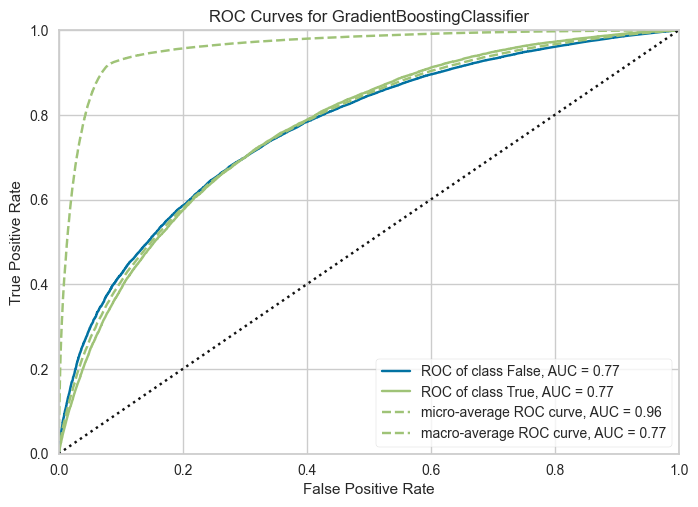

In [84]:
plot_model(tuned_gbc, plot = 'auc')

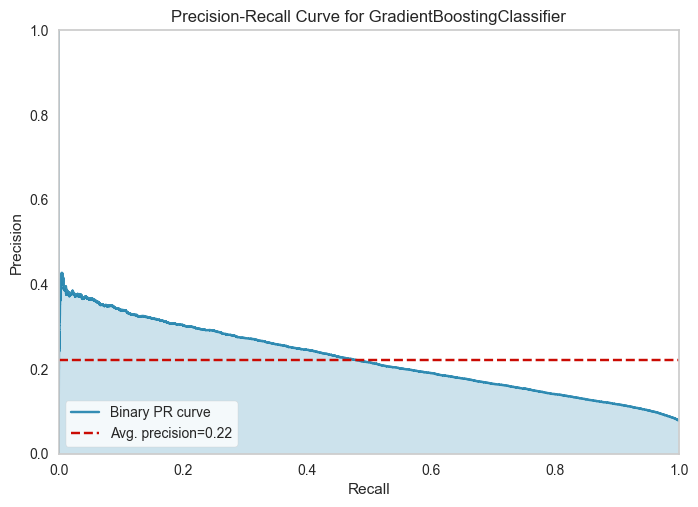

In [85]:
plot_model(tuned_gbc, plot = 'pr')

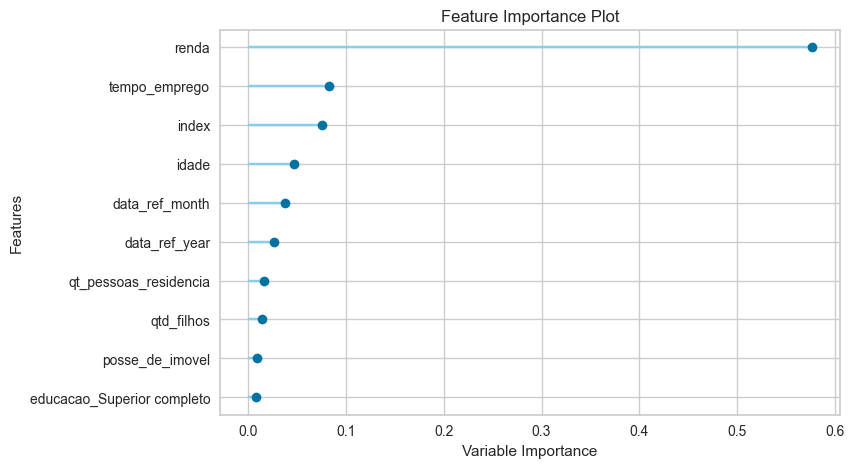

In [86]:
plot_model(tuned_gbc, plot='feature')

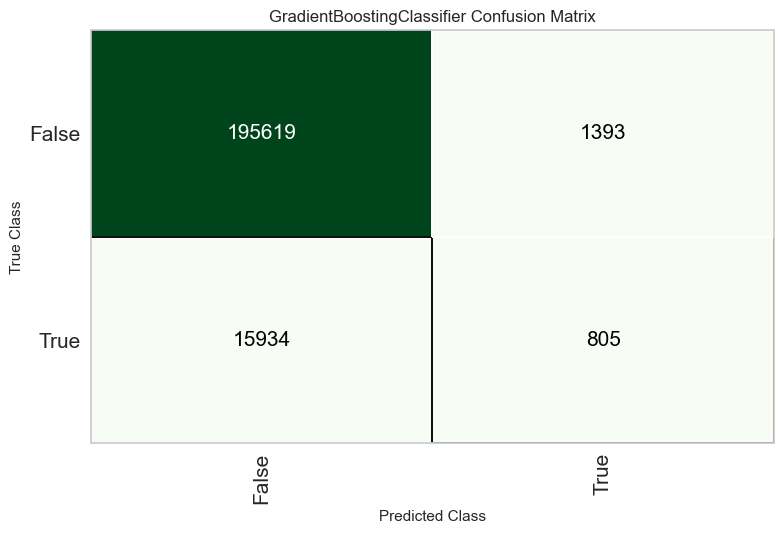

In [87]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [88]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [89]:
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9189,0.7684,0.0481,0.3662,0.0850,0.0681,0.1092


In [90]:
final_gbc = finalize_model(tuned_gbc)

In [91]:
predict_model(final_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9213,0.7801,0.0464,0.4770,0.0846,0.0717,0.1300


In [92]:
unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9224,0.7746,0.0379,0.3899,0.0691,0.0564,0.1022


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,2015-01-01,5033,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,False,0,0.8301
1,2015-01-01,1219,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,False,0,0.8808
2,2015-01-01,13262,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,False,0,0.6968
3,2015-01-01,13598,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,False,0,0.8928
4,2015-01-01,11700,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,False,0,0.8640


In [93]:
unseen_predictions.dtypes

data_ref                 datetime64[ns]
index                             int32
sexo                           category
posse_de_veiculo               category
posse_de_imovel                category
qtd_filhos                         int8
tipo_renda                     category
educacao                       category
estado_civil                   category
tipo_residencia                category
idade                              int8
tempo_emprego                   float32
qt_pessoas_residencia           float32
renda                           float32
mau                                bool
prediction_label                  int64
prediction_score                float64
dtype: object

In [96]:
save_model(final_gbc,'Final GBC Model 02Jun2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.4, loss='log_loss',
                                   